In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [208]:
DETECTORS_SIM = 12288
MODULES = 16
crystals_per_det = DETECTORS_SIM // MODULES

In [209]:
filename = '11_15_coin.lm'

data = np.memmap(filename, dtype=np.float32, mode='r')
data = data.reshape(-1, 10)

tofs = data[:, 3]

filename = '11_15_delay.lm'

delay = np.memmap(filename, dtype=np.float32, mode='r')
delay = delay.reshape(-1, 10)

deltofs = delay[:, 3]

filename = '11_15_actual.lm'

act = np.memmap(filename, dtype=np.float32, mode='r')
act = act.reshape(-1, 10)

acttofs = act[:, 3]

In [210]:
def rm_random(data, delay):

    coin = np.array([
        np.concatenate(( # coin lors followed by delay lors
            data[:, -2].astype(np.int64) * DETECTORS_SIM + data[:, -1].astype(np.int64), 
            delay[:, -2].astype(np.int64) * DETECTORS_SIM + delay[:, -1].astype(np.int64)
        )),
        np.concatenate(( # zeros followed by ones
            np.zeros(data.shape[0]),
            np.ones(delay.shape[0])
        )),
        np.concatenate(( # crystal ID 1s followed by delay crystal ID 1s
            data[:, -2],
            delay[:, -2]
        )),
        np.concatenate(( # crystal ID 2s followed by delay crystal ID 2s
            data[:, -1],
            delay[:, -1]
        )),
        np.concatenate(( # TOFs followed by delay TOFs
            data[:, 3],
            delay[:, 3]
        )),
    ],dtype=np.int64)
    
    #### subtract coin events which have same nearby delay events with same LOR id.

    index = np.linspace(0, data.shape[0] + delay.shape[0] - 1, data.shape[0] + delay.shape[0], dtype = np.int64)
    print(index.size)
    #### sort based on coin/delay id << time << LOR id
    argsort = np.lexsort((coin[1,:], coin[4,:], coin[0,:]))
    coin_sorted = coin[:,argsort]
    index = index[argsort]
    prev = 0

    for i in range(1000):
        #### same LOR crystal pair but one coin and one delay
        valid = np.insert((np.diff(coin_sorted[0,]) == 0)&(np.diff(coin_sorted[1,]) == 1),0,False)
        ###               --- within same LOR        ---  and next is delay but ours is coin ---
        valid2 = (coin_sorted[1,:] == 1) # is a delay
        curr = np.sum(valid2) # number of delays
        print("residual delay: ", curr) 
        if(curr == prev):
            index = index[~valid2] # gets rid of remaining delays
            break
        prev = curr 
        valid = valid | (np.insert(valid[1:],valid.size - 1,False)) # insert false at end
        print(np.unique(valid, return_counts=True))
        index = index[~valid]
        coin_sorted = coin_sorted[:,~valid]

    return index

In [211]:
def gen_sp_randoms(i, j, filename):
    def slice_sp(i, j):
        start_i = i * crystals_per_det
        stop_i = (i + 1) * crystals_per_det
        start_j = j * crystals_per_det
        stop_j = (j + 1) * crystals_per_det
        return slice(start_i, stop_i), slice(start_j, stop_j)
    
    sp = np.load(filename)
    sec = sp[slice_sp(i, j)]

    sec_int = np.floor(sec) + np.astype(np.random.rand(*sec.shape) < sec % 1, np.int64)
    sec_int = sec_int.astype(np.int64)
    sp_randoms = np.sum(sec_int)
    sp_gen = np.array([
        np.zeros(sp_randoms), np.zeros(sp_randoms), np.zeros(sp_randoms),
        np.random.rand(sp_randoms) * (np.max(tofs) - np.min(tofs)) + np.min(tofs),
        np.zeros(sp_randoms), np.zeros(sp_randoms), np.zeros(sp_randoms), np.zeros(sp_randoms),
        np.concatenate([np.full(np.int64(np.sum(sec_int[row])), row + i * crystals_per_det) for row in range(crystals_per_det)]),
        np.concat([np.repeat(np.arange(j * crystals_per_det, (j + 1) * crystals_per_det), sec_int[col]) for col in range(crystals_per_det)])
    ]).T

    return sp_gen

In [212]:
sps = gen_sp_randoms(11, 15, 'sp.npy')
sptofs = sps[:, 3]

In [213]:
delay_tofs = tofs[rm_random(data, delay)]
actual_tofs = tofs[rm_random(data, act)]
sp_tofs = tofs[rm_random(data, sps)]

25926759
residual delay:  8312112
(array([False,  True]), array([17029081,  8897678]))
residual delay:  3863273
(array([False,  True]), array([14530971,  2498110]))
residual delay:  2614218
(array([False,  True]), array([13435213,  1095758]))
residual delay:  2066339
(array([False,  True]), array([12867729,   567484]))
residual delay:  1782597
(array([False,  True]), array([12556527,   311202]))
residual delay:  1626996
(array([False,  True]), array([12386845,   169682]))
residual delay:  1542155
(array([False,  True]), array([12298555,    88290]))
residual delay:  1498010
(array([False,  True]), array([12255395,    43160]))
residual delay:  1476430
(array([False,  True]), array([12235523,    19872]))
residual delay:  1466494
(array([False,  True]), array([12227041,     8482]))
residual delay:  1462253
(array([False,  True]), array([12223545,     3496]))
residual delay:  1460505
(array([False,  True]), array([12222239,     1306]))
residual delay:  1459852
(array([False,  True]), array(

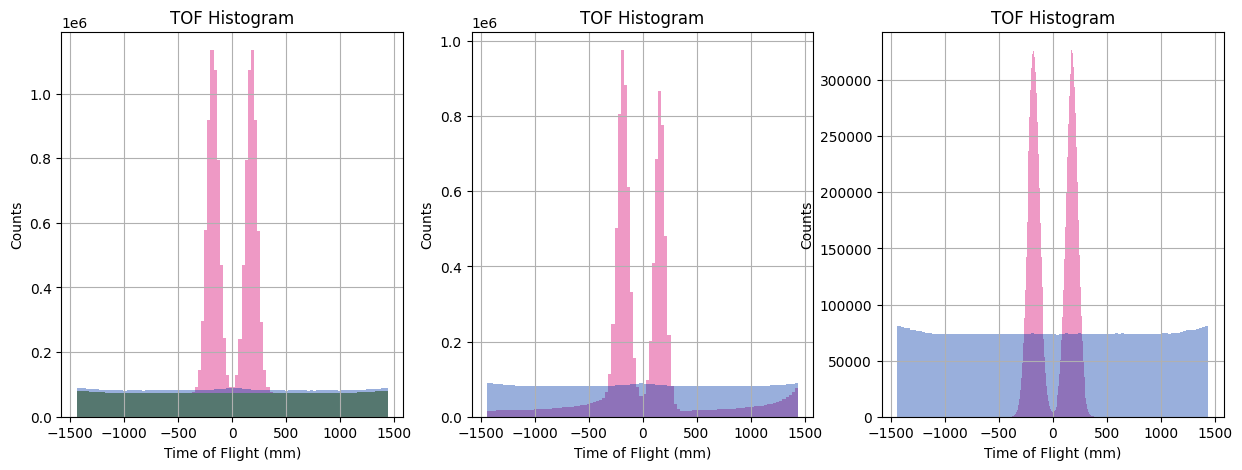

In [230]:
fig, (reg, dw, ac) = plt.subplots(1, 3, figsize=(15, 5))
reg.hist(tofs, bins=100, alpha=0.4, color='#D60270')
reg.hist(deltofs, bins=100, alpha=0.4, color='#0038A8')
reg.hist(acttofs, bins=100, alpha=0.4, color='green')
reg.set_xlabel('Time of Flight (mm)')
reg.set_ylabel('Counts')
reg.set_title('TOF Histogram')
reg.grid()

dw.hist(delay_tofs, bins=100, alpha=0.4, color='#D60270')
dw.hist(deltofs, bins=100, alpha=0.4, color='#0038A8')
dw.set_xlabel('Time of Flight (mm)')
dw.set_ylabel('Counts')
dw.set_title('TOF Histogram')
dw.grid()

ac.hist(actual_tofs, bins=100, alpha=0.4, color='#D60270')
ac.hist(acttofs, bins=100, alpha=0.4, color='#0038A8')
ac.set_xlabel('Time of Flight (mm)')
ac.set_ylabel('Counts')
ac.set_title('TOF Histogram')
ac.grid()

plt.show()

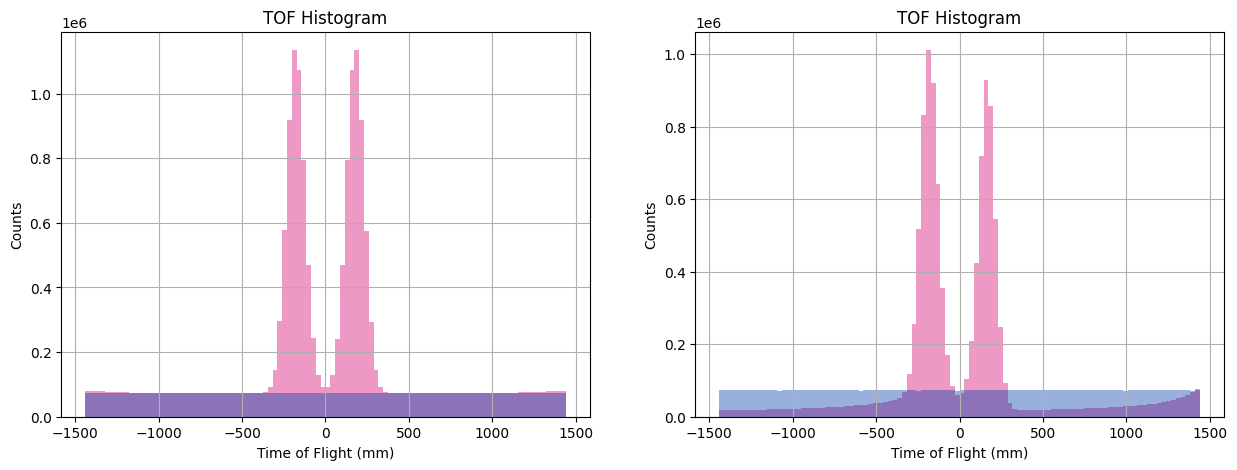

In [224]:
fig, (reg, sp) = plt.subplots(1, 2, figsize=(15, 5))
reg.hist(tofs, bins=100, alpha=0.4, color='#D60270')
reg.hist(sptofs, bins=100, alpha=0.4, color='#0038A8')
reg.set_xlabel('Time of Flight (mm)')
reg.set_ylabel('Counts')
reg.set_title('TOF Histogram')
reg.grid()

sp.hist(sp_tofs, bins=100, alpha=0.4, color='#D60270')
sp.hist(sptofs, bins=100, alpha=0.4, color='#0038A8')
sp.set_xlabel('Time of Flight (mm)')
sp.set_ylabel('Counts')
sp.set_title('TOF Histogram')
sp.grid()

plt.show()